# PREDECIR PREGUNTAS CERRADAS EN SOES - MODELOS
---


### **Instalación de librerias**

In [2]:
!pip install -q pandas_read_xml
!pip install -q xlsxwriter #Motor de escritura de archivos xlsx
!pip install -q stackapi

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 148 kB 4.9 MB/s 


In [3]:
import pandas as pd
import re
from nltk import word_tokenize
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import numpy as np
from sklearn import model_selection
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from keras import Sequential 
from keras.models import model_from_json
from tensorflow import keras
from stackapi import StackAPI
from datetime import datetime

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
es_stops = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Conexión a Google Drive**

In [5]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


### **Rutas a utilizar**

In [6]:
dataset = '/content/drive/MyDrive/PPC/data'
xlsx = '/content/drive/MyDrive/PPC/xlsx'
csv = '/content/drive/MyDrive/PPC/csv'
pkl = '/content/drive/MyDrive/PPC/pkl'
path_model = '/content/drive/MyDrive/PPC/model'

### **Uso del dataset**

In [8]:
data = pd.read_excel(dataset + '/closed_question.xlsx')

In [9]:
data.head(2)

,Id,Score,ViewCount,Body,OwnerUserId,Title,AnswerCount,CommentCount,FavoriteCount,ClosedDate,Tags,Id_User,Reputation,status_question,closing_reason
0,456059,-2,4,"<p>estoy introduciendo 2,8 millones de datos y...",230648,alguien sabe porq tarda mucho menos en volcar ...,0,2,0,2021-05-30T00:51:48.033,sql netbeans,230648,1,2,cerrada y eliminada
1,456057,0,15,"<p><strong>al estilo bootcamp, gamejam o simil...",230662,¿Que recomiendan para alguien deseando adquiri...,0,2,0,2021-05-30T00:51:17.387,java,230662,1,2,cerrada y eliminada


### **Funciones**

*Función de Preprocesado*

---



In [10]:
def regex(content):
    content = re.sub("\n", '', content) # Eliminación de Salto de Linea
    content = re.sub("&lt;", '<', content) # Sustitución de Codificación de caracteres
    content = re.sub("&gt;", '>', content) # Sustitución de Codificación de caracteres
    content = re.sub("&quot;", " ' ", content) # Sustitución de Codificación de caracteres
    content = re.sub("&amp;", " & ", content) # Sustitución de Codificación de caracteres
    content = re.sub("<\/?\w+>?", '', content) #Eliminación de etiquetas restantes manteniendo el contenido
    content = re.sub("[^a-zA-Z]", " ", content)
    return content

In [11]:
def preprocess(data):
    data = str(data) # Conversion de datos a cadena de texto
    data = data.lower() # Conversion a Minusculas
    data = regex(data) # LLamado a la Funcion regex
    for word in es_stops: # Eliminación de Stopwords
        token = ' ' + word + ' '
        data = data.replace(token, ' ')
    return data

*Función de preprocesado de etiquetas*

---



In [12]:
def del_labels(content):
  # content = re.sub("<c>", 'cb ', content)
  content = re.sub("<", '', content)
  content = re.sub(">", ' ', content)
  # content = re.sub("[++]", 'p', content)
  return content

In [13]:
def tags(data):
    data = str(data)
    data = data.lower() #Conversion a Minusculas
    data = del_labels(data)
    return data

*Función de Conteo de Palabras*

---



In [14]:
set_dict = set()
def text_clean(data):
    data = word_tokenize(data) #tokenizamos (ponemos una lista de palabras igual que split)
    [set_dict.add(palabra) for palabra in data] #almacenamos en un diccionario
    return len(data)

*Función de Preprocesamiento de etiquetas de API SOES*

In [15]:
def tags_query(data):
    data = str(data)
    data = data.lower() #Conversion a Minusculas
    data = del_labels(data)
    data = re.sub("[^a-zA-Z0-9_]", ' ', data)
    data = re.sub("   ", '', data)
    data = re.sub("  ", '', data)
    return data
# [^a-zA-Z0-9_]

### **Preparación del Dataset**

**Aplicación del Preprocesado**

In [16]:
data['Title'] = data.apply(lambda data: preprocess(data['Title']), axis=1)
data['Body'] = data.apply(lambda data: preprocess(data['Body']), axis=1)
data['Tags'] = data.apply(lambda data: tags(data['Tags']), axis=1)

**Conteo de palabras (Titulos, Cuerpo(sin codigo), Etiquetas)**

In [17]:
data['NumTags'] = data.apply(lambda data: text_clean(data['Tags']), axis=1)
data['NumTitle'] = data.apply(lambda data: text_clean(data['Title']), axis=1)
data['NumBody'] = data.apply(lambda data: text_clean(data['Body']), axis=1)

**Filtrado de etiquetas (Y)**

In [18]:
mask = data['closing_reason'].str.contains('duplicada|detalle o clarificacion|abierta|basada en opiniones|cerrada y eliminada') 
data = data[mask]

In [19]:
data.head()

,Id,Score,ViewCount,Body,OwnerUserId,Title,AnswerCount,CommentCount,FavoriteCount,ClosedDate,Tags,Id_User,Reputation,status_question,closing_reason,NumTags,NumTitle,NumBody
0,456059,-2,4,estoy introduciendo millones datos medir t...,230648,alguien sabe porq tarda menos volcar mismos da...,0,2,0,2021-05-30T00:51:48.033,sql netbeans,230648,1,2,cerrada y eliminada,2,12,12
1,456057,0,15,al estilo bootcamp gamejam simil si github ...,230662,recomiendan alguien deseando adquirir experie...,0,2,0,2021-05-30T00:51:17.387,java,230662,1,2,cerrada y eliminada,1,6,16
2,456036,0,5,he visto post aqui ninguno funcion ahora al...,230708,se puede utulizar sass preact,0,0,0,2021-05-30T00:36:17.873,sass,230708,1,2,cerrada y eliminada,1,5,12
3,456043,-1,7,me pueden ayudar necesito crear archivo texto ...,230715,crear archivo txt partir evento jbutton,0,2,0,2021-05-29T21:17:07.290,javascript,230715,1,2,cerrada y eliminada,1,6,24
4,456014,-2,7,la salida q busco ser punto recta ejemplo ...,230698,como puedo declarar q introducir varios datos ...,0,1,0,2021-05-29T19:30:03.577,cpp,230698,1,2,cerrada y eliminada,1,11,24


**Selección de las columnas categoricas a utilizar**

In [20]:
data = data[['Score','ViewCount','AnswerCount','CommentCount','FavoriteCount','Reputation','status_question','NumTags','NumTitle','NumBody','closing_reason']]

**Recuentos de filas de closing_reason (Razón del Cerrado)**

In [21]:
data['closing_reason'].value_counts()

duplicada                  2049
detalle o clarificacion    1476
abierta                    1138
basada en opiniones         718
cerrada y eliminada         206
Name: closing_reason, dtype: int64

**Reemplazamos el texto por numeros**

In [22]:
# data['closing_reason'] = data['closing_reason'].replace({"duplicada": 0,
#                  "detalle o clarificacion": 1,
#                  "fuera de tema": 2,
#                  "abierta": 3,
#                  "muy amplia": 4,
#                  "basada en opiniones": 5,
#                  "cerrada y eliminada": 6,
#                  })

data['closing_reason'] = data['closing_reason'].replace({"duplicada": 0,
                 "detalle o clarificacion": 1,
                 "abierta": 2,
                 "basada en opiniones": 3,
                 "cerrada y eliminada": 4,
                 })

In [23]:
data['closing_reason'].value_counts()

0    2049
1    1476
2    1138
3     718
4     206
Name: closing_reason, dtype: int64

**Guardar archivo para re-utilizar en los modelos**

---



In [24]:
data.to_pickle(dataset + '/data_train.pkl')

**Cargamos el archivo en la variable data (Checkpoint)** 

---



In [25]:
data = pd.read_pickle(dataset + '/data_train.pkl')

**Asignación de longitud de columna**

In [26]:
print("Total de columnas del dataset: ",len(data.columns))
i =len(data.columns)
i= i-1
print(i)

Total de columnas del dataset:  11
10


**Asignamos las columnas a X, Y**

In [27]:
X = data.iloc[::,0:i]

In [28]:
X.head()

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Reputation,status_question,NumTags,NumTitle,NumBody
0,-2,4,0,2,0,1,2,2,12,12
1,0,15,0,2,0,1,2,1,6,16
2,0,5,0,0,0,1,2,1,5,12
3,-1,7,0,2,0,1,2,1,6,24
4,-2,7,0,1,0,1,2,1,11,24


In [29]:
y = data.iloc[::,i]

In [30]:
y.head()

0    4
1    4
2    4
3    4
4    4
Name: closing_reason, dtype: int64

**División de los datos en conjuntos de entrenamiento y prueba**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [32]:
X_train.shape, X_test.shape

((3743, 10), (1844, 10))

# Modelo RandomForest

---



**Aplicación del modelo RandomForest**

In [33]:
n = 1000
rfc = RandomForestClassifier(random_state=0, n_estimators=n) # Se Instancia el clasificador
rfc.fit(X_train, y_train) # Construcción del bosque de árboles con el conjunto de entrenamiento (X, y)
y_pred = rfc.predict(X_test) # Prediccion con los datos de prueba

# Comprobar la puntuación de precisión
print('Puntuación de precisión del modelo con',n,'árboles de decisión : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Puntuación de precisión del modelo con 1000 árboles de decisión : 0.7202


In [34]:
rfc.predict(X_test)

array([1, 3, 4, ..., 0, 1, 2])

**Matriz de confusión**

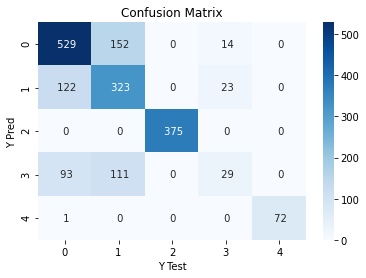

In [35]:
cm=confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm,cmap='Blues',annot=True,fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Y Test')
ax.set_ylabel('Y Pred')
sns.set(font_scale=1.5)

**Métricas de clasificación**

In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       695
           1       0.55      0.69      0.61       468
           2       1.00      1.00      1.00       375
           3       0.44      0.12      0.19       233
           4       1.00      0.99      0.99        73

    accuracy                           0.72      1844
   macro avg       0.74      0.71      0.71      1844
weighted avg       0.71      0.72      0.70      1844



**Importancias de las Características**

In [37]:
feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

status_question    0.330387
NumBody            0.141627
ViewCount          0.129119
Reputation         0.101903
Score              0.070853
NumTitle           0.065469
CommentCount       0.059730
AnswerCount        0.043583
NumTags            0.043439
FavoriteCount      0.013891
dtype: float64

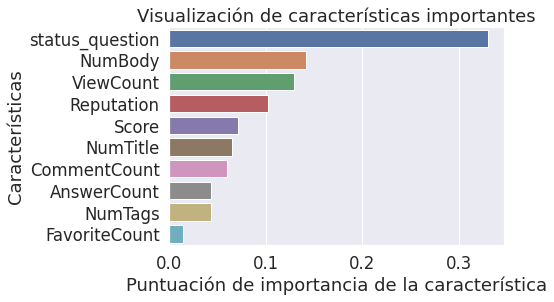

In [38]:
sns.barplot(x=feature_scores, y=feature_scores.index)

# Add labels to the graph
plt.xlabel('Puntuación de importancia de la característica')
plt.ylabel('Características')

# Add title to the graph

plt.title("Visualización de características importantes")

# Visualize the graph
plt.show()

# Modelo de Regresión Logística

---



In [39]:
data = pd.read_pickle(dataset + '/data_train.pkl')

In [40]:
array = data.values

In [41]:
X= data.drop(['closing_reason'],axis=1)

In [42]:
Y= data.closing_reason

In [43]:
test_size = 0.33
seed = 42
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [44]:
X.head()

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Reputation,status_question,NumTags,NumTitle,NumBody
0,-2,4,0,2,0,1,2,2,12,12
1,0,15,0,2,0,1,2,1,6,16
2,0,5,0,0,0,1,2,1,5,12
3,-1,7,0,2,0,1,2,1,6,24
4,-2,7,0,1,0,1,2,1,11,24


In [45]:
Y.head()

0    4
1    4
2    4
3    4
4    4
Name: closing_reason, dtype: int64

**Regresión Logística**

In [46]:
logreg = LogisticRegression(C=1.0, solver='newton-cg', max_iter=10000, verbose=False)
logreg.fit(X, Y)

# predict class probabilities for the actual testing data
oos_pred_prob = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [47]:
oos_pred_prob

array([1, 0, 4, ..., 0, 0, 2])

In [48]:
print('Model logisticRegression : {0:0.4f}'. format(accuracy_score(Y_test, oos_pred_prob)))

Model logisticRegression : 0.6725


Text(22.5, 0.5, 'Y Pred')

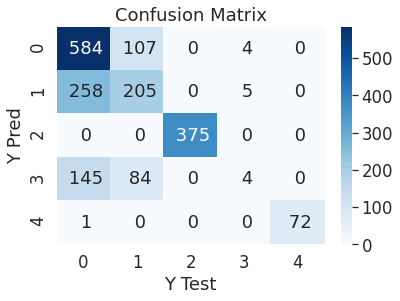

In [49]:
cm=confusion_matrix(Y_test,oos_pred_prob)
ax=sns.heatmap(cm,cmap='Blues',annot=True,fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Y Test')
ax.set_ylabel('Y Pred')

In [50]:
print(classification_report(Y_test,oos_pred_prob))

              precision    recall  f1-score   support

           0       0.59      0.84      0.69       695
           1       0.52      0.44      0.47       468
           2       1.00      1.00      1.00       375
           3       0.31      0.02      0.03       233
           4       1.00      0.99      0.99        73

    accuracy                           0.67      1844
   macro avg       0.68      0.66      0.64      1844
weighted avg       0.64      0.67      0.63      1844



# Modelo de Keras (Redes Neuronales)

In [51]:
data = pd.read_pickle(dataset + '/data_train.pkl')

In [52]:
array = data.values

In [53]:
array

array([[ -2,   4,   0, ...,  12,  12,   4],
       [  0,  15,   0, ...,   6,  16,   4],
       [  0,   5,   0, ...,   5,  12,   4],
       ...,
       [  0,  30,   1, ...,  12,  86,   2],
       [  0,  17,   0, ...,   7,  65,   2],
       [  0,  53,   0, ...,   3, 243,   2]])

In [54]:
data_train = array[ : , 0:i]
etiqueta = array[ : , i]

test_size = 0.33
seed = 42

x_train, x_test, Y_train, Y_test = model_selection.train_test_split(data_train, etiqueta, test_size=test_size, random_state=seed)

In [55]:
Y_test

array([3, 3, 4, ..., 0, 1, 2])

In [56]:
X = np.asarray(x_train, dtype=np.float32)
Y = np.asarray(Y_train, dtype=np.int32)

X_test = np.asarray(x_test, dtype=np.float32)
Y_test = np.asarray(Y_test, dtype=np.float32)

In [57]:
model = Sequential()

model.add(Dense(32, input_dim=10, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
print("Comenzando entrenamiento...")
kr = model.fit(X, Y, validation_data=(X_test,Y_test),epochs=1000, batch_size=100)
print("Modelo entrenado!")

Comenzando entrenamiento...
Epoch 1/1000
38/38 [==============================] - 1s 9ms/step - loss: 48.3051 - accuracy: 0.2757 - val_loss: 12.1962 - val_accuracy: 0.2842
Epoch 2/1000
38/38 [==============================] - 0s 3ms/step - loss: 9.4908 - accuracy: 0.3118 - val_loss: 12.6857 - val_accuracy: 0.3004
Epoch 3/1000
38/38 [==============================] - 0s 3ms/step - loss: 9.4943 - accuracy: 0.3115 - val_loss: 19.4913 - val_accuracy: 0.3080
Epoch 4/1000
38/38 [==============================] - 0s 3ms/step - loss: 11.4620 - accuracy: 0.3112 - val_loss: 11.3892 - val_accuracy: 0.3617
Epoch 5/1000
38/38 [==============================] - 0s 3ms/step - loss: 9.6378 - accuracy: 0.3452 - val_loss: 8.4932 - val_accuracy: 0.3080
Epoch 6/1000
38/38 [==============================] - 0s 3ms/step - loss: 6.3316 - accuracy: 0.3313 - val_loss: 8.1426 - val_accuracy: 0.3460
Epoch 7/1000
38/38 [==============================] - 0s 3ms/step - loss: 5.6500 - accuracy: 0.3110 - val_loss: 5.

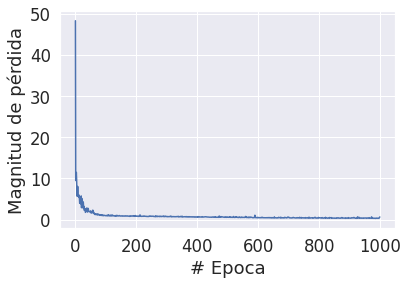

In [59]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(kr.history["loss"])

In [60]:
predictions = model.predict(X_test)


pre_final=np.argmax(predictions,axis=1)
pre_final

array([1, 1, 4, ..., 0, 1, 2])

Text(22.5, 0.5, 'Y Pred')

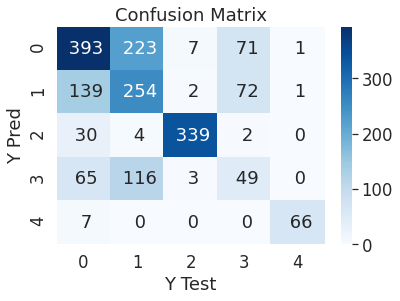

In [61]:
cm=confusion_matrix(Y_test,pre_final)
ax=sns.heatmap(cm,cmap='Blues',annot=True,fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Y Test')
ax.set_ylabel('Y Pred')

In [62]:
print(classification_report(Y_test,pre_final))

              precision    recall  f1-score   support

         0.0       0.62      0.57      0.59       695
         1.0       0.43      0.54      0.48       468
         2.0       0.97      0.90      0.93       375
         3.0       0.25      0.21      0.23       233
         4.0       0.97      0.90      0.94        73

    accuracy                           0.60      1844
   macro avg       0.65      0.63      0.63      1844
weighted avg       0.61      0.60      0.60      1844



### **Guardado de modelos**

In [63]:
import joblib
# Keras
model.save(path_model + '/keras.h5')
# Random Forest
joblib.dump(rfc, path_model + '/rfc.joblib')
# Regresion Lineal
joblib.dump(logreg, path_model + '/rl.joblib')

['/content/drive/MyDrive/PPC/model/rl.joblib']

# BUSQUEDA

---



In [64]:
def dec2char(txt):
  print(txt)
  chars = list(filter(None,re.findall("(?!&#)\d*(?=;)", txt)))
  for char in chars:
    matches = list(re.finditer("&#\d*;", txt)) 
    begin = matches[0].start(0)
    end = matches[0].end(0)
    txt = txt[:begin] + chr(int(char)) + txt[end:]
  print(txt)
  return txt

### **Extracción de data de API SO**

In [65]:
SITE = StackAPI('es.stackoverflow')
SITE.page_size = 100
SITE.max_pages = 10
questions = SITE.fetch('questions',  fromdate=datetime(2021,7,6), order='desc', filter='withbody')

id_lst_es = []
title_lst_es = []
body_lst_es = []
user_ids_lst_es = []
tags_lst_es = []
links_lst_es = []
score = []
owner_lst_es = []
a_count = []
v_count = []

for item in questions['items']:
  id_lst_es.append(item.get('question_id'))
  item['title'] = dec2char(item['title'])
  title_lst_es.append(item.get('title'))
  body_lst_es.append(item.get('body'))
  score.append(item.get('score'))
  a_count.append(item.get('answer_count'))
  v_count.append(item.get('view_count'))
  tags_lst_es.append(item.get('tags'))
  
  tags_d2c = []
  for tag in item.get('tags'):
    tags_d2c.append(dec2char(tag))
  tags_lst_es.append(tags_d2c)

  owner_lst_es.append(item.get('owner'))
  links_lst_es.append(item.get('link'))
  try:
      user_ids_lst_es.append(item['owner']['user_id'])
  except:
      user_ids_lst_es.append('X')
  

soes_df = pd.DataFrame(list(zip(id_lst_es,
                                user_ids_lst_es, 
                                title_lst_es, 
                                body_lst_es, 
                                tags_lst_es, 
                                links_lst_es, 
                                score,
                                a_count,
                                v_count,
                                owner_lst_es
)), columns =['Id',
              'Owner_id',
              'Title',
              'Body',
              'Tags', 
              'Link',
              'Score',
              'AnswerCount',
              'ViewCount',
              'owner']) 

Se han truncado las últimas 5000 líneas del flujo de salida.
java
java
&#191;Como trabajar con Vue.js si poseo dos APIs?
¿Como trabajar con Vue.js si poseo dos APIs?
javascript
javascript
html
html
vue.js
vue.js
api
api
fetch
fetch
Esperar a que termine dispatch Redux
Esperar a que termine dispatch Redux
reactjs
reactjs
react-native
react-native
expo
expo
##[error]Solution not found using search pattern &#39;D:\a\1\s\**\*.sln&#39;
##[error]Solution not found using search pattern 'D:\a\1\s\**\*.sln'
github
github
azure
azure
pipeline
pipeline
yaml
yaml
Error MultiValueDictKeyError en request.get en django
Error MultiValueDictKeyError en request.get en django
python
python
django
django
Galer&#237;a de imagenes, &#191;C&#243;mo puedo mostrar cada una de ellas en el lightbox?
Galería de imagenes, ¿Cómo puedo mostrar cada una de ellas en el lightbox?
javascript
javascript
html
html
jquery
jquery
Como puedo crear un arreglo Y que contenga los n&#250;meros impares del 0 al 255
Como puedo cre

In [66]:
soes_df.head()

,Id,Owner_id,Title,Body,Tags,Link,Score,AnswerCount,ViewCount,owner
0,483810,152654,eliminar LI a una UL,"<p><div class=""snippet"" data-lang=""js"" data-hi...","[javascript, html]",https://es.stackoverflow.com/questions/483810/...,0,2,17,"{'reputation': 363, 'user_id': 152654, 'user_t..."
1,482674,150344,¿Existe posibilidad de agregar una imagen a tr...,<p>Quiero añadir una imagen en un extremo a un...,"[javascript, html]",https://es.stackoverflow.com/questions/482674/...,0,0,21,"{'reputation': 405, 'user_id': 150344, 'user_t..."
2,483512,150344,Cómo armar el enlace sacando la información de...,"<p>No sé nada de python, pero lo que me intere...","[javascript, html, css, html5, css3]",https://es.stackoverflow.com/questions/483512/...,0,0,21,"{'reputation': 405, 'user_id': 150344, 'user_t..."
3,483855,82732,No puedo obtener los registros entre las fecha...,<p>estoy tratando de obtener los registros que...,"[javascript, html, css, html5, css3]",https://es.stackoverflow.com/questions/483855/...,0,0,5,"{'reputation': 9, 'user_id': 82732, 'user_type..."
4,483854,178318,Colocar enlace de menú en Moodle con liga a un...,<p>Intento redireccionar un enlace de mi menú ...,"[javascript, python]",https://es.stackoverflow.com/questions/483854/...,0,0,2,"{'reputation': 1356, 'user_id': 178318, 'user_..."


In [67]:
soes_df['Title'] = soes_df.apply(lambda soes_df: preprocess(soes_df['Title']), axis=1)
soes_df['Body'] = soes_df.apply(lambda soes_df: preprocess(soes_df['Body']), axis=1)
soes_df['Tags'] = soes_df.apply(lambda soes_df: tags_query(soes_df['Tags']), axis=1)

In [68]:
soes_df['NumTags'] = soes_df.apply(lambda soes_df: text_clean(soes_df['Tags']), axis=1)
soes_df['NumTitle'] = soes_df.apply(lambda soes_df: text_clean(soes_df['Title']), axis=1)
soes_df['NumBody'] = soes_df.apply(lambda soes_df: text_clean(soes_df['Body']), axis=1)

In [69]:
soes_df

,Id,Owner_id,Title,Body,Tags,Link,Score,AnswerCount,ViewCount,owner,NumTags,NumTitle,NumBody
0,483810,152654,eliminar li ul,class snippet data lang js data hide fal...,javascript html,https://es.stackoverflow.com/questions/483810/...,0,2,17,"{'reputation': 363, 'user_id': 152654, 'user_t...",2,3,245
1,482674,150344,existe posibilidad agregar imagen trav s be...,quiero adir imagen extremo linea mapa recorre ...,javascript html,https://es.stackoverflow.com/questions/482674/...,0,0,21,"{'reputation': 405, 'user_id': 150344, 'user_t...",2,8,74
2,483512,150344,c mo armar enlace sacando informaci n python c...,no s python interesa entender c mo va constr...,javascript html css html5 css3,https://es.stackoverflow.com/questions/483512/...,0,0,21,"{'reputation': 405, 'user_id': 150344, 'user_t...",5,12,132
3,483855,82732,no puedo obtener registros fechas laravel,estoy tratando obtener registros cumplan con...,javascript html css html5 css3,https://es.stackoverflow.com/questions/483855/...,0,0,5,"{'reputation': 9, 'user_id': 82732, 'user_type...",5,6,42
4,483854,178318,colocar enlace men moodle liga bloque dentro ...,intento redireccionar enlace men moodle bloqu...,javascript python,https://es.stackoverflow.com/questions/483854/...,0,0,2,"{'reputation': 1356, 'user_id': 178318, 'user_...",2,11,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,482075,248056,qu css agrega estilos p gina html,estoy haciendo p gina vscode momento empezar a...,java,https://es.stackoverflow.com/questions/482075/...,-2,1,31,"{'reputation': 1, 'user_id': 248056, 'user_typ...",1,7,14
996,482086,226240,tengo error execution failed for task app co...,href https i stack imgur com yhck png re...,cfunciones,https://es.stackoverflow.com/questions/482086/...,0,0,12,"{'reputation': 1, 'user_id': 226240, 'user_typ...",1,8,61
997,467220,22289,convertir octal hexadecimal da resultado incor...,tengo c digo button click pretende convertir n...,cfunciones,https://es.stackoverflow.com/questions/467220/...,0,1,35,"{'reputation': 767, 'user_id': 22289, 'user_ty...",1,6,318
998,480271,112484,posicionar dos elementos adaptables ancho pant...,en contenedor principal dos div cu l trato am...,html reactjs material ui dialog,https://es.stackoverflow.com/questions/480271/...,0,2,45,"{'reputation': 79, 'user_id': 112484, 'user_ty...",5,6,177


In [ ]:
soes_df.to_excel(xlsx + '/data_qw.xlsx', encoding='utf-8',  engine='xlsxwriter')


### **Leer archivo de query**

In [70]:
query = pd.read_excel(xlsx + '/Querys.xlsx')
datos = query
query = query[['Score','ViewCount','AnswerCount','CommentCount','FavoriteCount','Reputation','status_question','NumTags','NumTitle','NumBody']]


### **Cargar Modelos**

In [71]:
keras_model = keras.models.load_model(path_model +'/keras.h5')
rf_model = joblib.load(path_model + '/rfc.joblib')
rl_model = joblib.load(path_model + '/rl.joblib')

In [73]:
datos[0:15]

,Id,Owner_id,Title,Body,Tags,Link,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Reputation,status_question,NumTags,NumTitle,NumBody
0,477327,149360,como saber posicion diccionario elemento sacar...,eso pues arreglo ejemplo ...,c,https://es.stackoverflow.com/questions/477327/...,0,43,1,7,0,21,0,1,7,36
1,477158,213114,se puede bloquear descarga im genes carpeta pu...,les comento aplicaci n react carga muchas im g...,angular typescript angular10 wysiwyg,https://es.stackoverflow.com/questions/477158/...,0,7,0,0,0,21,0,4,9,50
2,477122,231162,como puedo generar traves bd link dinamicamente,encontre codigo youtube hice forma tira error...,php sql base de datos pdf,https://es.stackoverflow.com/questions/477122/...,1,33,1,3,1,43,0,6,7,98
3,477197,232975,error usar operador ternario,tengo siguiente c digo error est operador ter...,javascript html css,https://es.stackoverflow.com/questions/477197/...,0,49,1,2,0,149,1,3,4,308
4,477240,136223,funcion flecha vs funcion regular,siguiendo tutorial vue hace fetch api regresa...,php update img,https://es.stackoverflow.com/questions/477240/...,0,32,1,1,0,456,1,3,5,115
5,478555,245356,como programadores aprenden lenguajes programa...,como aprendieron programar ustedes decir hacen...,javascript php mysql,https://es.stackoverflow.com/questions/478555/...,-1,26,0,5,-1,1,1,3,5,40
6,478612,183610,qu muestra bien datos solo muestra null,alguien sabe hora querer mostrar output pelic...,c,https://es.stackoverflow.com/questions/478612/...,0,40,0,0,0,179,2,1,7,189
7,478331,62580,jbutton jareatext din micos java,disculpen nuevo usando swings java dilema nec...,java mysql appserv,https://es.stackoverflow.com/questions/478331/...,0,19,0,0,0,1,2,3,5,53
8,478602,245457,relaciones claves embedded hibernate,se presento situaci n sabiendo resolver embe...,android android studio flutter dart avd,https://es.stackoverflow.com/questions/478602/...,0,8,0,0,0,1,2,6,4,141
9,478320,243611,se puede acceder ir buscar carpeta especifico ...,necesito crear programa python ejecutarlo d...,angular,https://es.stackoverflow.com/questions/478320/...,1,16,0,10,0,11,1,1,14,24


In [74]:
query[0:15]

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Reputation,status_question,NumTags,NumTitle,NumBody
0,0,43,1,7,0,21,0,1,7,36
1,0,7,0,0,0,21,0,4,9,50
2,1,33,1,3,1,43,0,6,7,98
3,0,49,1,2,0,149,1,3,4,308
4,0,32,1,1,0,456,1,3,5,115
5,-1,26,0,5,-1,1,1,3,5,40
6,0,40,0,0,0,179,2,1,7,189
7,0,19,0,0,0,1,2,3,5,53
8,0,8,0,0,0,1,2,6,4,141
9,1,16,0,10,0,11,1,1,14,24


In [75]:
X_prueba = np.asarray(query[0:15], dtype=np.float32)

In [76]:
rf_model.predict(X_prueba).astype("int32")

array([2, 2, 2, 0, 0, 0, 4, 4, 4, 1, 1, 1, 1, 0, 1], dtype=int32)

In [77]:
prueba = keras_model.predict(X_prueba).astype("int32")
prueba_final=np.argmax(prueba,axis=1)
prueba_final

array([0, 0, 2, 0, 0, 0, 0, 4, 4, 3, 1, 1, 0, 0, 0])

In [78]:
rl_model.predict(X_prueba).astype("int32")

array([2, 2, 2, 0, 0, 0, 4, 4, 4, 0, 0, 0, 1, 0, 0], dtype=int32)

"duplicada": 0,
"detalle o clarificacion": 1,
"abierta": 2,
"basada en opiniones": 3,
"cerrada y eliminada": 4,